# **PYED**: Exact diagonalization for finite quantum systems

Copyright (C) 2017, H. U.R. Strand

The python module `pyed` implements exact diagonalization for finite fermionic many-body quantum systems, together with calculations of several response functions in imagianary time.

The many-body system is defined using `pytriqs` second-quantized operators and the response functions are stored in `pytriqs` Green's function containters.

## Hamiltonians

As an example let us solve the Hubbard atom with Hamiltonian $H = U\hat{n}_{\uparrow} \hat{n}_{\downarrow} - \mu ( \hat{n}_{\uparrow} + \hat{n}_{\downarrow})$, where $\hat{n}_\sigma = c^\dagger_\sigma c_\sigma$.


In [1]:
import warnings
warnings.filterwarnings('ignore')

In [11]:
from pytriqs.operators import c, c_dag
up, down = 'up', 'down'
n_up = c_dag(up, 0) * c(up, 0)
n_down = c_dag(down, 0) * c(down, 0)

U = 1
mu =-0.5*U

H = U * n_up * n_down + mu * (n_up + n_down)

print 'H =', H

H = -0.5*c_dag('down',0)*c('down',0) + -0.5*c_dag('up',0)*c('up',0) + 1*c_dag('down',0)*c_dag('up',0)*c('up',0)*c('down',0)


## Thermal equilibrium solution

To solve the thermal equilibrium of the system we can diagonalize $H$ and determine the partition function $\mathcal{Z}$ (or alternatively the free energy $\Omega = -\frac{1}{\beta} \ln \mathcal{Z}$) and the many-body density matrix $\rho$ using the egenstates $|\Gamma \rangle$ and eigenvalues $E_\Gamma$ of $H$. The partition function $\mathcal{Z}$ is given by the sum of Boltzman weights

$$
\mathcal{Z} = \sum_\Gamma e^{-\beta E_\Gamma} \, ,
$$
while the many-body density matrix is given by the ket-bra Boltzman weighted sum

$$
\rho = \frac{1}{\mathcal{Z}} \sum_\Gamma e^{-\beta E_\gamma} |\Gamma \rangle \langle \Gamma|
\, .
$$

To accomplish this we pass the Hamiltonian $H$ and a list of unique annihilation opeators used in $H$ together with the inverse temperature $\beta$ to a `pyed.TriqsExactDiagonalization` class instance:

In [12]:
beta = 4.0 # inverse temperature
fundamental_operators = [c(up,0), c(down,0)]

from pyed.TriqsExactDiagonalization import TriqsExactDiagonalization
ed = TriqsExactDiagonalization(H, fundamental_operators, beta)

print r'Z =', ed.get_partition_function()
print r'\Omega =', ed.get_free_energy()
print r'\rho ='
print ed.ed.get_density_matrix()

100%|██████████| 4/4 [00:00<00:00, 470.75it/s]

Hamiltonian diagonalization:
Z = 2.2706705664732256
\Omega = -0.7050187979007294
\rho =
  (0, 0)	0.05960146101105877
  (1, 1)	0.44039853898894116
  (2, 2)	0.44039853898894116
  (3, 3)	0.05960146101105877


### Thermal expectation values

Using the many-body density matrix we can evaluate the expectation value of any operator $\mathcal{O}$ by taking the trace

$$
\langle \mathcal{O} \rangle = \textrm{Tr} [ \rho \mathcal{O} ]
$$


In [13]:
print '<n_up>   =', ed.get_expectation_value(n_up)
print '<n_down> =', ed.get_expectation_value(n_down)
print '<n_up * n_down> =', ed.get_expectation_value(n_up * n_down)

<n_up>   = 0.5
<n_down> = 0.5
<n_up * n_down> = 0.05960146101105877


## Imaginary time single-particle Green's function
We can also calculate the dynamical fluctuations of the system by computing its response functions. The simples case is the single-particle Green's function, defined as the imaginary time ordered expectation value

$$
 G_{\sigma \sigma'}(\tau) \equiv
   - \langle \mathcal{T} \, c_{\sigma}(\tau) c_{\sigma'}^\dagger(0) \rangle
 =
 - \frac{1}{\mathcal{Z}} \text{Tr}
     \left[ e^{-\beta H} c_{\sigma}(\tau_1) c_{\sigma'}^\dagger(0) \right]
$$
where the imaginary time dependent operators are defined in the Heisenberg picture $c_{\sigma}(\tau) \equiv e^{\tau H} c_{\sigma} e^{-\tau H}$ and $c^\dagger_{\sigma}(\tau) \equiv e^{\tau H} c^\dagger_{\sigma} e^{-\tau H}$.

To calculate $G(\tau)$ we first create `pytriqs.GfImTime` instance to store the result and pass it to our ED solver instance:

100%|██████████| 500/500 [00:00<00:00, 1714.22it/s]


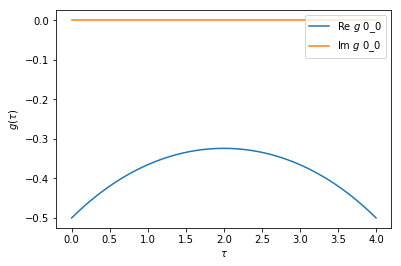

In [14]:
from pytriqs.gf import GfImTime
g_tau = GfImTime(name=r'$g$', beta=beta, statistic='Fermion', n_points=500, indices=[1])    
ed.set_g2_tau(g_tau, c(up,0), c_dag(up,0))

import matplotlib.pyplot as plt
from pytriqs.plot.mpl_interface import oplot
%matplotlib inline

plt.figure(); oplot(g_tau); plt.savefig('figure_g_tau.png')

The two-operator response function calculator is more general and can be used to calculate any type of two operator response, e.g., the density-density response function: $\chi_{\sigma \sigma'}(\tau) \equiv -\langle \hat{n}_\sigma(\tau) \hat{n}_\sigma' \rangle$. However for the very simple single-Hubbard-atom system this response function is $\tau$ independent as seen below:


100%|██████████| 1000/1000 [00:00<00:00, 1987.30it/s]


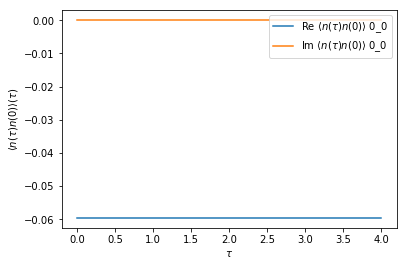

In [15]:
from pytriqs.gf import GfImTime
densdens_tau = GfImTime(name=r'$\langle n(\tau) n(0) \rangle$', beta=beta, statistic='Boson', n_points=1000, indices=[1])    
ed.set_g2_tau(densdens_tau, n_up, n_down)

plt.figure(); oplot(densdens_tau); plt.savefig('figure_densdens_tau.png')

For fermionic two-operator response functions `pyed` can also directly calculate the fourier transformed response function

$$
G(i \omega_n) \equiv \int_0^\beta d\tau \, e^{i\omega_n \tau} G(\tau)
$$
defined on the (fermionic) Matsubara frequencies $i\omega_n = \frac{2\pi}{\beta}(2n + 1)$. 

<span style="color:red">NB! `pyed` currently lacks support for handling bosonic response functions in frequency.</span>

100%|██████████| 200/200 [00:00<00:00, 22229.13it/s]


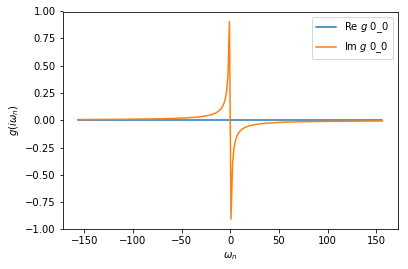

In [16]:
from pytriqs.gf import GfImFreq
g_iwn = GfImFreq(name=r'$g$', beta=beta, statistic='Fermion', n_points=100, indices=[1])
ed.set_g2_iwn(g_iwn, c(up,0), c_dag(up,0))

plt.figure(); oplot(g_iwn); plt.savefig('figure_g_iwn.png')

# Four-operator response functions

In `pyed` there is functionality to compute also higher-order response functions (involving more than two operators and more than one time). Currently two- and three- time ordered expectation values are supported solely in imaginary time.

The two-particle Green's function $G^{(4)}(\tau_1, \tau_2, \tau_3)$ is a prominent example

$$
G^{(4)}_{\alpha\bar{\beta}\gamma\bar{\delta}}(\tau_1, \tau_2, \tau_3) \equiv
\langle \mathcal{T} 
c_\alpha(\tau_1) c^\dagger_{\bar{\beta}} (\tau_2) 
c_\gamma(\tau_3) c^\dagger_{\bar{\delta}} (0)  \rangle
$$

That easily can be calculated with `pyed` by passing a suitable `pytriqs` container to the ED solver:


In [17]:
from pytriqs.gf import Gf
from pytriqs.gf import MeshImTime, MeshProduct

ntau = 20
imtime = MeshImTime(beta, 'Fermion', ntau)
prodmesh = MeshProduct(imtime, imtime, imtime)

g4_tau = Gf(name=r'$G^{(4)}(\tau_1,\tau_2,\tau_3)$', mesh=prodmesh, target_shape=[1, 1, 1, 1])
ed.set_g4_tau(g4_tau, c(up,0), c_dag(up,0), c(up,0), c_dag(up,0))

100%|██████████| 1140/1140 [00:01<00:00, 942.44it/s]


To visualize this three dimensional scalar field one have to resort to some cut plane to represent it in a two dimensional plot. So instead of plotting $G^{(4)}$ we here show the special case of a two-time response function correspoding to $G^{(4)}(\tau_1, 0^-, \tau_2)$ namely the particle-particle equal time response function

$$
G_{\alpha \beta \gamma}^{(3)}(\tau_1, \tau_2) \equiv 
\langle \mathcal{T} c_{\alpha}(\tau_1) c^\dagger_{\bar{\beta}}(\tau_2) \hat{n}_\gamma(0)\rangle \equiv 
- \langle \mathcal{T} c_{\alpha}(\tau_1) c^\dagger_{\bar{\beta}}(\tau_2) c_{\gamma}(0^-) c^\dagger_{\bar{\gamma}}(0) \rangle \equiv 
- G^{(4)}(\tau_1, \tau_2, 0^+)
\, ,
$$
that can be calculated separately as:


In [18]:
prodmesh2 = MeshProduct(imtime, imtime)
g3pp_tau = Gf(name=r'$G^{(3)}(\tau_1, \tau_2)$', mesh=prodmesh2, target_shape=[1, 1, 1, 1])
ed.set_g3_tau(g3pp_tau, c(up,0), c_dag(up,0), c(up,0)*c_dag(up,0))

100%|██████████| 190/190 [00:00<00:00, 999.15it/s] 



To visualize this we use `matplotlib` directly


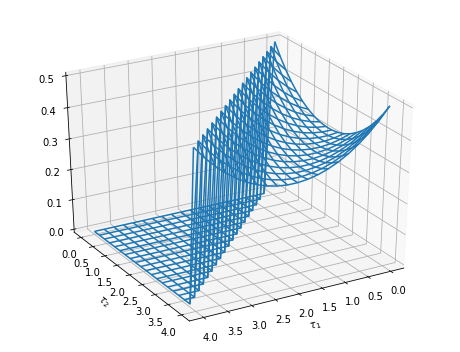

In [19]:
import numpy as np
from mpl_toolkits.mplot3d import axes3d
fig = plt.figure(figsize=(3.25*2, 2*2.5))
ax = fig.add_subplot(1,1,1, projection='3d')

data = g3pp_tau.data[:, :, 0, 0, 0, 0]
tau = [tau.real for tau in g3pp_tau.mesh.components[0]]
t1, t2 = np.meshgrid(tau, tau)
ax.plot_wireframe(t1, t2, data.real)
ax.view_init(30, 60)
ax.set_xlabel(r'$\tau_1$')
ax.set_ylabel(r'$\tau_2$')
plt.tight_layout()
plt.savefig('figure_g3pp_tau.png')